In [1]:
import torch
import numpy as np
import sys, os, glob
from PIL import Image
import warnings # get this for MacOS: https://discuss.pytorch.org/t/failed-to-load-image-python-extension-could-not-find-module/140278/8
from typing import Tuple, Dict, Optional, List
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.neighbors import KNeighborsRegressor

In [2]:
train_flag = False
dataset_name = "cities_dataset"
auxiliary_data_dir = "geo-estimator-auxiliary-data"
dataset_dir = os.path.join(auxiliary_data_dir, dataset_name)

In [3]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Metal GPU acceleration!")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using Nvidia Cuda acceleration!")
print()

Using Nvidia Cuda acceleration!



# Download the data and checkpoints

In [4]:
if not os.path.exists(auxiliary_data_dir):
    os.system("git clone https://github.com/ldcWV/geo-estimator-auxiliary-data.git")

# ImageDataset to (lazily) load images and associated metadata

In [5]:
warnings.filterwarnings("ignore", category=UserWarning)  # no more nasty torch warnings

In [6]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir: str = None):
        super().__init__()
        self.data_dir = data_dir
        self.image_dir = "images"
        # self.image_dir = os.path.join(self.image_dir, "lowres")  # use low-res (TODO: parameterize)
        self.dataset_size = len( #only care about images!
            glob.glob(os.path.join(data_dir, self.image_dir, "*.jpg"))
        )
        self.gps_compass = np.loadtxt(os.path.join(data_dir, "gps_compass.txt"))[:,:2] # get lat,lon but ignore compass
        assert len(self.gps_compass) >= self.dataset_size
        # get the resolution for the images
        example_im: str = os.path.join(data_dir, self.image_dir, "000001_4.jpg")
        assert os.path.exists(example_im)
        # initialize transformations
        # see https://pytorch.org/hub/pytorch_vision_vgg/
        self.preprocess = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(  # for VGG-net
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                )
            ]
        )
        self.im_res = (self.preprocess(Image.open(example_im))).shape
        # for preloading the images
        self.cache = {}

    def compute_size_mb(self, data: Dict[int, Tuple[torch.Tensor]]) -> float:
        if len(data) == 0:
            return 0
        # assume all the data elements are the same size (in terms of memory)
        c, h, w = self.im_res
        size = c * w * h * 4  # 4 bytes (float) for a c-channel image of size w * h
        return len(data) * size / 1e6

    def preload(self) -> None:
        num_load: int = len(self)
        print(f"Preloading {num_load} data entries! (this might take a while)")
        for i in range(num_load):
            # pre-load all the data in memory so it can be accessed FAST
            self.cache[i] = self[i]
            mb = self.compute_size_mb(self.cache)
            print(
                f"Preload complete: {100 * i / num_load:.1f}% ({mb:.2f}Mb)",
                end="\r",
                flush=True,
            )
        print()
        print(f"Done, consumed {mb:.2f}Mb")

    def __len__(self) -> int:
        return self.dataset_size

    # given an image index, return the image itself as well as its associated metadata
    def __getitem__(
        self, idx: int, view: int = 4
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        assert 0 <= idx < self.dataset_size
        assert 0 <= view <= 5
        if idx in self.cache:
            return self.cache[idx]
        # TODO: keep a running batch of images loaded in memory (limited to some number) and
        # use this as a running queue for fast img access time
        img_path = os.path.join(self.data_dir, self.image_dir, f"{idx:06d}_{view}.jpg")
        if not os.path.exists(img_path):
            return None, None
        im: torch.Tensor = self.preprocess(Image.open(img_path))
        # can't compute gradients with uint8 :((
        # im = (255 * im).type(torch.uint8)  # to uint8 to save memory (vs float32)
        # return image (tensor), tuple of cartesian coords (x, y, z), and tuple of GPS & compass (lat, long, compass)
        return (
            im.to(device),
            torch.from_numpy(self.gps_compass[idx]).type(torch.float32).to(device),
        )

# CNN implementation and training

In [7]:
# main parameters to tune
batch_size: int = 32  # number of training instances happening at once (in parallel)
seed: int = 1  # to fix the randomness
torch.manual_seed(seed)
epochs: int = 3000
eval_iter: int = 200
lr: float = 0.00001
fc_dim: int = 5000  # dimensionality of the final fully connected layer
dropout: float = 0.2  # percent of indermediate calculations that are disabled
regularization: float = 0.00001  # regularization strength
momentum: float = 0.9
ckpt_dir: str = "ckpt"
os.makedirs(ckpt_dir, exist_ok=True)

In [8]:
def latlongdist(lat1, lon1, lat2, lon2):
    # credit to https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
    p = torch.pi/180
    a = 0.5 - torch.cos((lat2-lat1)*p)/2 + torch.cos(lat1*p) * torch.cos(lat2*p) * (1-torch.cos((lon2-lon1)*p))/2
    return 12742 * torch.asin(torch.sqrt(a))

In [33]:
class GeoGuesser(torch.nn.Module):
    # inspiration from https://arxiv.org/pdf/1512.03385.pdf

    def __init__(
        self,
        dataset: torch.utils.data.Dataset,
        im_res: torch.Size,
        train_idxs: torch.Tensor,
        test_idxs: torch.Tensor,
    ):
        super().__init__()
        self.dataset = dataset
        # don't track these buffers as "model parameters"
        self.register_buffer("train_idxs", train_idxs, persistent=False)
        self.register_buffer("test_idxs", test_idxs, persistent=False)

        self.im_res = im_res
        c, h, w = self.im_res

        # create the network
        self.out_size = 2  # lat, lon

        class ConvReluBlock(torch.nn.Module):
            def __init__(self, in_size: int, out_size: int, kernel_size: int):
                super().__init__()
                self.network = torch.nn.Sequential(
                    torch.nn.Conv2d(
                        in_channels=in_size,
                        out_channels=out_size,
                        kernel_size=kernel_size,
                        stride=1,
                        bias=False,
                        padding=kernel_size // 2,  # maintain shape!
                    ),
                    torch.nn.ReLU(inplace=True),
                )

            def forward(self, x):
                # print(x.shape)
                return self.network.forward(x)
        
        class ScaleToLatLong(torch.nn.Module):
            def __init__(self):
                super().__init__()
            def forward(self, x):
                scale = torch.Tensor([90, 180]).to(x.device)
                return x * scale

        self.network = torch.nn.Sequential(
            ConvReluBlock(in_size=c, out_size=24, kernel_size=3),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            ConvReluBlock(in_size=24, out_size=30, kernel_size=3),
            torch.nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4)),
            torch.nn.ReLU(inplace=True),
            # finall FC7 (layer)
            torch.nn.Flatten(),  # convert to latent vector space for FC layer
            torch.nn.Linear(23520, fc_dim),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(fc_dim, self.out_size),  # final FC layer
            torch.nn.Tanh(), # Scale output to between -1 and 1
            ScaleToLatLong()
        )

        print(f"State dict: {list(self.state_dict().keys())}")

    def forward(
        self, x: torch.Tensor, y: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        if len(x.shape) == 3:  # no batch, single image
            x = torch.unsqueeze(x, dim=0)  # batch of 1
        B, C, H, W = x.shape  # (batch, channels, height, width)
        logits = self.network.forward(x)
        if y is not None and len(y.shape) == 1:  # no batch, single sample
            y = torch.unsqueeze(y, dim=0)  # batch of 1
        loss = self.loss_function(logits, y) if y is not None else None
        return logits, loss

    def loss_function(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        B = x.shape[0]  # batch size
        assert x.shape == (B, self.out_size)
        assert y.shape == x.shape
        
        lat1, lon1 = x[:, 0], x[:, 1]
        lat2, lon2 = y[:, 0], y[:, 1]
        km_distance = latlongdist(lat1, lon1, lat2, lon2)
        return torch.mean(km_distance)

    def sample_batch(
        self, type: str = "train"
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # return a randomized batch of data from the corresponding dataset
        data = self.train_idxs if type == "train" else self.test_idxs
        start_idx = torch.randint(low=1, high=data.max() - 1, size=(batch_size, 1))
        data = [self.dataset[int(i)] for i in start_idx]
        images = torch.stack([image for image, _ in data])
        gps = torch.stack([gps for _, gps in data])
        assert images.shape == (batch_size, *self.im_res)
        assert gps.shape == (batch_size, 2)
        return images, gps

    def load(self) -> None:
        ckpt_path = os.path.join(auxiliary_data_dir, f"{dataset_name}_ckpt.pt")
        print(ckpt_path)
        if os.path.exists(ckpt_path):
            with open(ckpt_path, "rb") as f:
                self.load_state_dict(torch.load(f))
                print(f'Loaded state dict from "{ckpt_path}" successfully!')
                print()
        else:
            print(f'No ckpt found @ "{ckpt_path}"')

    def begin_training(self):
        self.train()
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=lr,
            weight_decay=regularization,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        train_loss, val_loss = self.estimate_loss()  # initial losses
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            img, gps = self.sample_batch()
            _, loss = self.forward(img, gps)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            print(
                f"Epoch {epoch:>4}/{epochs} \t ({100 * epoch / epochs:.1f}%) \t Train loss: {train_loss:.2f} \t Val loss: {val_loss:.2f}",
                end="\r",
                flush=True,
            )
            if epoch % eval_iter == 0 and epoch > 0:
                print()
                train_loss, val_loss = self.estimate_loss(num_iters=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                torch.save(self.state_dict(), f"{dataset_name}_ckpt.pt")
                scheduler.step(loss)
        print()
        print(
            f"Epoch {epochs}/{epochs} \t ({100:.1f}%) \t Train loss: {train_loss:.2f} \t Val loss: {val_loss:.2f}"
        )
        torch.save(self.state_dict(), f"{dataset_name}_ckpt.pt")
        return train_losses, val_losses

    # create a loss estimator for averaging training and val loss
    def estimate_loss(self, num_iters: int = 20) -> Tuple[float, float]:
        losses: Dict[str, float] = {}
        with torch.no_grad():  # no need to track gradients (lower memory footprint)
            self.eval()  # switch to evaluation mode
            for split in ["train", "valid"]:
                cumulative_loss: float = 0
                for i in range(num_iters):
                    img, gps = self.sample_batch(split)
                    _, loss = self.forward(img, gps)
                    cumulative_loss += loss.item()
                    print(
                        f"({split}) Eval: {100 * i / num_iters:.0f}%",
                        end="\r",
                        flush=True,
                    )
                losses[split] = cumulative_loss / num_iters
            self.train()  # back to training phase
        # https://stackoverflow.com/questions/5419389/how-to-overwrite-the-previous-print-to-stdout
        for x in range(75):  # line clearing
            print("*" * (75 - x), x, end="\x1b[1K\r")
        return losses["train"], losses["valid"]

# Training/running the CNN

In [34]:
dataset = ImageDataset(dataset_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 5.5863, -0.2440], device='cuda:0')


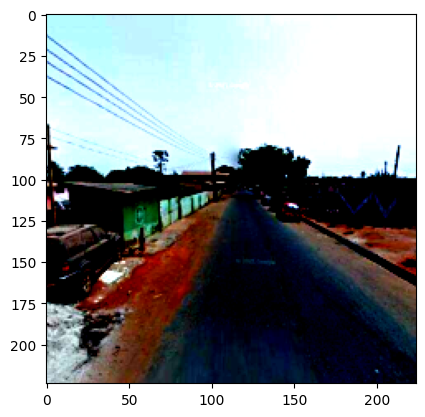

In [35]:
# examples
image, gps = dataset[1]
plt.imshow(torch.permute(image, (1,2,0)).cpu().detach().numpy())
print(gps)

In [36]:
torch.manual_seed(1)
idxs = torch.randperm(len(dataset))

In [37]:
# use 90% for training, 10% for test
test_train_split: int = int(0.9 * len(idxs))
train = idxs[:test_train_split]
test = idxs[test_train_split:]

In [38]:
m = GeoGuesser(dataset, image.shape, train, test)
m = m.to(device)
print(m)

State dict: ['network.0.network.0.weight', 'network.2.network.0.weight', 'network.6.weight', 'network.6.bias', 'network.9.weight', 'network.9.bias']
GeoGuesser(
  (network): Sequential(
    (0): ConvReluBlock(
      (network): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
      )
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ConvReluBlock(
      (network): Sequential(
        (0): Conv2d(24, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
      )
    )
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    (4): ReLU(inplace=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=23520, out_features=5000, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=5000, out_feature

In [39]:
pred, _ = m.forward(image)
print(pred)

tensor([[  1.3843, -11.4896]], device='cuda:0', grad_fn=<MulBackward0>)


In [40]:
if train_flag:
    train_losses, val_losses = m.begin_training()
else:
    m.load()

geo-estimator-auxiliary-data\cities_dataset_ckpt.pt
Loaded state dict from "geo-estimator-auxiliary-data\cities_dataset_ckpt.pt" successfully!



In [41]:
if train_flag:
    epochs = [(i+1)*200 for i in range(len(train_losses))]
    plt.plot(epochs, train_losses, '-.', label="train loss")
    plt.plot(epochs, val_losses, label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"CNN loss for {dataset_name}")
    plt.legend()
    plt.show()

# CNN Demo

Enter an index (0-10000): 80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted location [32.5109    3.443771]
Actual location [ 5.5705132  -0.24484465]


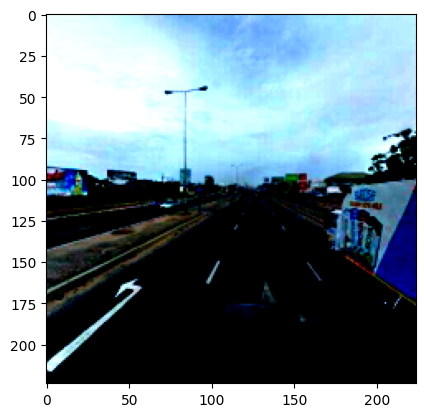

In [68]:
idx = int(input("Enter an index (0-10000):"))
image, y = dataset[idx]
plt.imshow(torch.permute(image, (1,2,0)).cpu().detach().numpy())
yhat = m(image)[0][0]
print("Predicted location", yhat.cpu().detach().numpy())
print("Actual location", y.cpu().detach().numpy())

# KNN Implementation

In [18]:
gps_compass = np.loadtxt(os.path.join(dataset_dir, "gps_compass.txt"))

In [19]:
def get_data(idx: int):
    preprocess = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor()
    ])
    img_path = os.path.join(dataset_dir, "images", f"{idx:06d}_4.jpg")
    
    if not os.path.exists(img_path):
        return None, None
    
    img = torch.permute(preprocess(Image.open(img_path)), (1,2,0)).numpy()
    latlng = gps_compass[idx,:2]
    
    return (img, latlng)

In [20]:
X = []
y = []
dataset_size = len(glob.glob(os.path.join(dataset_dir, "images", "*.jpg")))
for i in range(dataset_size):
    img, latlng = get_data(i)
    if img is None:
        continue
    img = img.flatten()
    X.append(img)
    y.append(latlng)

In [21]:
N = len(X)

In [22]:
X_train = X[:int(0.9*N)]
y_train = y[:int(0.9*N)]
X_test = X[int(0.9*N):]
y_test = y[int(0.9*N):]

In [85]:
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train, y_train)
y_hat = neigh.predict(X_test)

y_test = torch.Tensor(y_test)
y_hat = torch.Tensor(y_hat)
lat1, lon1 = y_test[:, 0], y_test[:, 1]
lat2, lon2 = y_hat[:, 0], y_hat[:, 1]
km_distance = latlongdist(lat1, lon1, lat2, lon2)
print(torch.mean(km_distance))

tensor(9370.2393)


Enter an index (0-10000): 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted location [27.76076349 85.60129038]
Actual location [44.430016 26.074831]


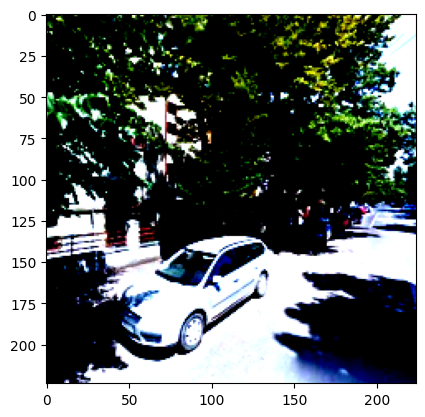

In [75]:
idx = int(input("Enter an index (0-10000):"))
image, y = dataset[idx]
plt.imshow(torch.permute(image, (1,2,0)).cpu().detach().numpy())
yhat = neigh.predict([get_data(idx)[0].flatten()])[0]
print("Predicted location", yhat)
print("Actual location", y.cpu().detach().numpy())